In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.


In [3]:
def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

In [4]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    debug: bool = False
    outdir: str = "results02"
    device: str = "cuda:2"
    device_id: int = 2

    # Data config
    imgconf_file: str = '../../data/VinBigData/train.csv'
    meta_file: str = '../../data/VinBigData/train_meta.csv'
    imgdir_name: str = "../../data/VinBigData/png1024"
    img_size: int = 1024
    seed: int = 111
    n_splits: int = 5
    iou_thr: float = 0.5
    skip_box_thr: float = 0.0001
    
    # Training config
    batch_size: int = 8
    patience: int = 10
    epochs: int = 20
    train_aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
    valid_aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
    test_aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [5]:
config_dict = {
    'debug': False,
    'batch_size': 25,
    'patience': 10,
    'epochs': 100,
    'iou_thr': 0.4,
    'skip_box_thr': 0.0001,
    "train_aug_kwargs": {
        'HorizontalFlip': {'p': 0.5},
#         'VerticalFlip': {'p': 0.5},
#         'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5},
#         'GaussNoise': {'var_limit': 0.002, 'p': 0.5},
#         'Blur': {'blur_limit': (3, 10), 'p': 0.5},
#         'RandomBrightnessContrast': {'p': 0.5},
#         'Cutout': {'num_holes': 20, 'max_h_size': 20, 'max_w_size': 20, 'p': 0.5},
        "Normalize": {"mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225)}
    },
    "valid_aug_kwargs": {
        "Normalize": {"mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225)}
    },
    "test_aug_kwargs": {
        "Normalize": {"mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225)}
    },
}
config = Config().update(config_dict)
config.to_yaml(base_dir / config.outdir / 'config.yaml')

In [6]:
classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
classes_dict = {index + 1: class_name  for index, class_name in enumerate(classes_nms)} # background (id = 0)

In [7]:
def load_train_data(filepath: str, meta_filepath: str, img_size: int) -> pd.DataFrame:
    train = pd.read_csv(filepath)
    train.fillna(0, inplace=True)
    train.loc[train["class_id"] == 14, ['x_max', 'y_max']] = 1.0
    
    train_meta = pd.read_csv(meta_filepath)
    
    train = pd.merge(train, train_meta, how='left', on='image_id')
    
    train[f'x_min_{img_size}'] = (img_size / train['dim1'] * train['x_min']).astype(int)
    train[f'x_max_{img_size}'] = (img_size / train['dim1'] * train['x_max']).astype(int)
    train[f'y_min_{img_size}'] = (img_size / train['dim0'] * train['y_min']).astype(int)
    train[f'y_max_{img_size}'] = (img_size / train['dim0'] * train['y_max']).astype(int)
    
    return train

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
class FasterRCNNVinBigDataset(VinBigDataset):
    def __init__(self, dataset_dicts: Dict[str, Any], transform: Transform, train: bool = True):
        super().__init__(dataset_dicts=dataset_dicts, transform=transform, train=train)
        
        for i in range(len(self.dataset_dicts)):
            n_annot = len(self.dataset_dicts[i]['annotations'])
            for j in range(n_annot):
                self.dataset_dicts[i]['annotations'][j]['category_id'] += 1 # background (id = 0)

In [10]:
from ensemble_boxes import *


def change_wbf(dataset_dict: Dict[str, Any], iou_thr: float, skip_box_thr: float, n_cls: int):
    cls_ids = list(range(n_cls))
    
    height, width = dataset_dict['height'], dataset_dict['width']
    
    boxes = list()
    labels = list()
    scores = [1.0] * len(dataset_dict['annotations'])
        
    for obj in dataset_dict['annotations']:
        box = [
            obj['bbox'][0] / width,
            obj['bbox'][1] / height,
            obj['bbox'][2] / width,
            obj['bbox'][3] / height
        ]
        boxes += [box]
        labels += [obj['category_id']]
    
    boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    annots = list()
    for box_, label_ in zip(boxes, labels):
        annots += [{
            'bbox': [
                box_[0] * width,
                box_[1] * height,
                box_[2] * width,
                box_[3] * height
            ],
            'category_id': label_
        }]
        
    return {
        'file_name': dataset_dict['file_name'],
        'image_id': dataset_dict['image_id'],
        'height': height,
        'width': width,
        'annotations': annots
    }

In [11]:
train = load_train_data(filepath=str(base_dir / config.imgconf_file), meta_filepath=str(base_dir / config.meta_file), img_size=config.img_size)
# mkf = MultilabelKFoldWrapper(train, n_splits=config.n_splits, seed=config.seed)

In [12]:
dataset_dicts = get_vinbigdata_dicts(
    imgdir=base_dir / config.imgdir_name,
    meta_filepath=base_dir / config.meta_file,
    train_df=train,
    train_data_type=f'png{config.img_size}',
    debug=config.debug,
)

Load from cache dataset_dicts_cache_png1024_debug0.pkl


In [13]:
# remove no finding
dataset_dicts = [dd for dd in dataset_dicts if len(dd['annotations']) > 0]
# label cleaning
dataset_dicts = [change_wbf(dd, iou_thr=config.iou_thr, skip_box_thr=config.skip_box_thr, n_cls=len(classes_dict)) for dd in dataset_dicts]

In [14]:
# check outdir
assert len([f for f in os.listdir(str(base_dir / config.outdir)) if 'fold' in f]) == 0

In [15]:
cols = ['x_min', 'y_min', 'x_max', 'y_max']
train_ = train.drop(columns=['x_min', 'y_min', 'x_max', 'y_max']).rename(columns={f'{c}_{config.img_size}': c for c in cols})
train_['class_id'] += 1

In [17]:
random.seed(config.seed)
rnd_idx = random.sample(list(range(len(dataset_dicts))), len(dataset_dicts))
train_idx, valid_idx = rnd_idx[:int(len(rnd_idx) * 0.8)], rnd_idx[int(len(rnd_idx) * 0.8):]

In [18]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


seed_everything(seed=config.seed, device=config.device)
outdir = base_dir / config.outdir

train_dataset = FasterRCNNVinBigDataset(dataset_dicts=[dataset_dicts[i] for i in train_idx], transform=Transform(config.train_aug_kwargs, train=True))
valid_dataset = FasterRCNNVinBigDataset(dataset_dicts=[dataset_dicts[i] for i in valid_idx], transform=Transform(config.valid_aug_kwargs, train=True))

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

train_evaluator = VinBigDataEval(train_.query(f'image_id in {train_dataset.image_ids}'))
valid_evaluator = VinBigDataEval(train_.query(f'image_id in {valid_dataset.image_ids}'))

early_stop_callback = EarlyStopping(monitor='valid_mAP@.4', min_delta=0.00, patience=config.patience, verbose=True, mode='max')
trainer = pl.Trainer(gpus=[config.device_id], max_epochs=config.epochs, weights_summary='full', callbacks=[early_stop_callback])

detector = ObjectDetector(model=load_faster_rcnn(num_classes=len(classes_dict) + 1), train_evaluator=train_evaluator, valid_evaluator=valid_evaluator, outdir=outdir)
trainer.fit(detector, train_loader, valid_loader)

detector.to_dataframe().to_csv(str(outdir / 'history.csv'))
torch.save(detector.state_dict(), str(outdir / 'model_last.pt'))

Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

    | Name                                      | Type                     | Params
-----------------------------------------------------------------------------------------
0   | model                                     | FasterRCNN               | 41.4 M
1   | model.transform                           | GeneralizedRCNNTransform | 0     
2   | model.backbone                            | BackboneWithFPN          | 26.8 M
3   | model.backbone.body                       | IntermediateLayerGetter  | 23.5 M
4   | model.backbone.body.conv1                 | Conv2d                   | 9.4 K 
5   | model.backbone.body.bn1                   | FrozenBatchNorm2d        | 0     
6   | model.backbone.body.relu                  | ReLU                     | 0     
7   | model.backbone.body.maxpool               | MaxPool2d                | 0     
8   | model.backbone.body.layer1                | Sequential               | 212 

Validation sanity check: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.73s).
Accumulating evaluation results...
DONE (t=0.11s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.000
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.000
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.000
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.000
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.75s).
Accumulating evaluation results...
DONE (t=0.11s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.008
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.009
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.008
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.015
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.015
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.32s).
Accumulating evaluation results...
DONE (t=0.23s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.076
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.148
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.106
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.091
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.084
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.217
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.223
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.65s).
Accumulating evaluation results...
DONE (t=0.26s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.117
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.118
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.146
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.152
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.127
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.301
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.307
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.56s).
Accumulating evaluation results...
DONE (t=0.54s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.170
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.280
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.251
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.210
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.190
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.488
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.500
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.88s).
Accumulating evaluation results...
DONE (t=0.35s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.212
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.294
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.230
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.275
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.242
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.579
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.594
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.79s).
Accumulating evaluation results...
DONE (t=0.33s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.251
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.335
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.199
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.322
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.278
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.580
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.599
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.99s).
Accumulating evaluation results...
DONE (t=0.32s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.275
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.376
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.291
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.338
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.283
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.640
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.655
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.63s).
Accumulating evaluation results...
DONE (t=0.37s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.298
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.281
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.242
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.375
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.280
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.608
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.625
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.21s).
Accumulating evaluation results...
DONE (t=0.38s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.297
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.327
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.313
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.346
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.300
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.707
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.719
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.28s).
Accumulating evaluation results...
DONE (t=0.51s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.308
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.274
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.343
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.375
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.304
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.739
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.766
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.94s).
Accumulating evaluation results...
DONE (t=0.37s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.324
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.385
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.307
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.370
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.312
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.720
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.735
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.37s).
Accumulating evaluation results...
DONE (t=0.42s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.320
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.319
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.334
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.386
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.323
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.752
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.774
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.77s).
Accumulating evaluation results...
DONE (t=0.34s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.327
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.319
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.362
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.397
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.329
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.710
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.727
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.01s).
Accumulating evaluation results...
DONE (t=0.33s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.332
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.239
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.297
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.414
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.319
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.692
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.713
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.90s).
Accumulating evaluation results...
DONE (t=0.35s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.345
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.263
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.354
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.407
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.336
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.745
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.764
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.18s).
Accumulating evaluation results...
DONE (t=0.43s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.313
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.416
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.335
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.349
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.314
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.743
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.768
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.93s).
Accumulating evaluation results...
DONE (t=0.37s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.340
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.314
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.342
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.389
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.320
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.727
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.748
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.90s).
Accumulating evaluation results...
DONE (t=0.56s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.347
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.269
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.299
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.416
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.323
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.723
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.744
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.98s).
Accumulating evaluation results...
DONE (t=0.35s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.361
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.233
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.309
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.438
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.328
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.733
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.750
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.24s).
Accumulating evaluation results...
DONE (t=0.43s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.348
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.309
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.337
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.404
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.340
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.793
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.815
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.69s).
Accumulating evaluation results...
DONE (t=0.31s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.346
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.261
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.285
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.426
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.321
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.685
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.706
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.80s).
Accumulating evaluation results...
DONE (t=0.31s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.350
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.222
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.302
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.422
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.335
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.703
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.720
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.15s).
Accumulating evaluation results...
DONE (t=0.38s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.355
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.309
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.299
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.425
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.330
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.757
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.783
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.62s).
Accumulating evaluation results...
DONE (t=0.30s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.346
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.260
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.304
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.411
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.333
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.702
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.717
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.86s).
Accumulating evaluation results...
DONE (t=0.36s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.342
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.286
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.263
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.425
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.336
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.736
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.755
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.96s).
Accumulating evaluation results...
DONE (t=0.33s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.351
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.243
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.254
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.427
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.331
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.731
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.749
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.97s).
Accumulating evaluation results...
DONE (t=0.33s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.344
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.231
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.285
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.431
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.337
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.721
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.736
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.92s).
Accumulating evaluation results...
DONE (t=0.31s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.350
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.250
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.306
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.432
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.347
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.728
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.743
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

Validating: 0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.04s).
Accumulating evaluation results...
DONE (t=0.33s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.342
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.259
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.246
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.419
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.338
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.726
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.748
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | max

In [17]:
# from typing import List, Tuple

# import matplotlib.patches as patches
# import numpy as np
# from PIL import Image


# def add_bboxes_to_image(ax, image: np.ndarray,
#                         bboxes: List[Tuple[int, int, int, int]],
#                         labels: List[str] = None,
#                         label_size: int = 10,
#                         line_width: int = 2,
#                         border_color=(0, 1, 0, 1)) -> None:
#     """
#     Add bbox to ax

#     :param image: dtype=np.uint8
#     :param bbox: [(left, top, right, bottom)]
#     :param label: List[str] or None
#     :return: ax
#     """
#     # Display the image
#     ax.imshow(image)

#     if labels is None:
#         labels = [None] * len(bboxes)

#     for bbox, label in zip(bboxes, labels):
#         # Add bounding box
#         x_min, y_min, x_max, y_max = bbox
#         rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
#                                  linewidth=line_width,
#                                  edgecolor=border_color,
#                                  facecolor='none')
#         ax.add_patch(rect)

#         # label
#         if label:
#             bbox_props = dict(boxstyle="square,pad=0",
#                               linewidth=line_width, facecolor=border_color,
#                               edgecolor=border_color)
#             ax.text(x_min, y_min, label,
#                     ha="left", va="bottom", rotation=0,
#                     size=label_size, bbox=bbox_props)
#     return ax

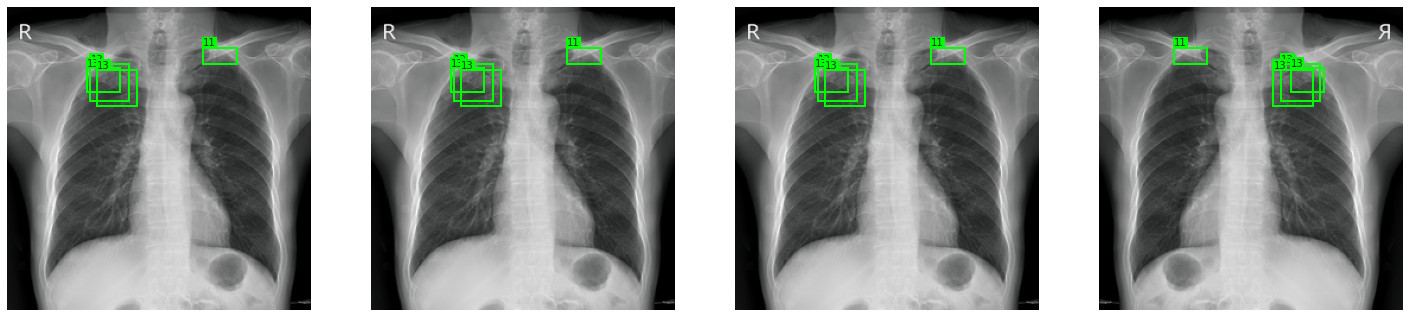

In [19]:
# fig, axes = plt.subplots(1, 4, figsize=(25, 8))
# for ax in axes:
#     img, target, _ = train_dataset[0]
#     img = np.maximum(0, img.numpy().transpose((1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
#     add_bboxes_to_image(ax, np.uint8(img), target['boxes'], target['labels'].numpy())
#     ax.axis("off")
# plt.show()